For Stereotopy classificication, we take the coordinate prediciton data for the snout and centroid and use those as features for classification. We use a sequence length of one minute for classificaiton.

![title](stereotopy_flowchart.png)

In [0]:
# library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import tensorflow as tf


To train the model, we need the prediction output from DeeplabCut as well as ground truth annotations for stereotypy. The directories below should be modified to include the locations of these files on your local machine



In [0]:
stereotopy_gt=pd.read_excel('/content/drive/My Drive/stereotopy_prediction_data/trial7_stereo_complete.xlsx',header=0)
Marker_predictions_1=pd.read_csv('/content/drive/My Drive/stereotopy_prediction_data/Test7PART1DLC_resnet50_Trial3Mar23shuffle1_10000.csv',header=1)[["snout","snout.1","centroid","centroid.1"]]
Marker_predictions_2=pd.read_csv('/content/drive/My Drive/stereotopy_prediction_data/Test7PART2DLC_resnet50_Trial3Mar23shuffle1_10000.csv',header=1)[["snout","snout.1","centroid","centroid.1"]]
Marker_predictions_3=pd.read_csv('/content/drive/My Drive/stereotopy_prediction_data/Test7PART3DLC_resnet50_Trial3Mar23shuffle1_10000.csv',header=1)[["snout","snout.1","centroid","centroid.1"]]
Marker_predictions_4=pd.read_csv('/content/drive/My Drive/stereotopy_prediction_data/Test7PART4DLC_resnet50_Trial3Mar23shuffle1_10000.csv',header=1)[["snout","snout.1","centroid","centroid.1"]]
Marker_predictions_5=pd.read_csv('/content/drive/My Drive/stereotopy_prediction_data/Test7PART5DLC_resnet50_Trial3Mar23shuffle1_10000.csv',header=1)[["snout","snout.1","centroid","centroid.1"]]

stereotopy_gt_1=stereotopy_gt[6:25].to_numpy()
stereotopy_gt_2=stereotopy_gt[31:50].to_numpy()
stereotopy_gt_3=stereotopy_gt[56:75].to_numpy()
stereotopy_gt_4=stereotopy_gt[81:100].to_numpy()
stereotopy_gt_5=stereotopy_gt[106:125].to_numpy()

Marker_predictions_1=Marker_predictions_1.iloc[825:17925].to_numpy().astype(float) # start at 55 seconds after and end at the 20th exactly
Marker_predictions_2=Marker_predictions_2.iloc[825:17925].to_numpy().astype(float)
Marker_predictions_3=Marker_predictions_3.iloc[825:17925].to_numpy().astype(float)
Marker_predictions_4=Marker_predictions_4.iloc[825:17925].to_numpy().astype(float)
Marker_predictions_5=Marker_predictions_5.iloc[825:17925].to_numpy().astype(float)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
Marker_predictions=np.concatenate((Marker_predictions_1,Marker_predictions_2,Marker_predictions_3,Marker_predictions_4,Marker_predictions_5))
data_stereotopy_labels=np.concatenate((stereotopy_gt_1[:,1],stereotopy_gt_2[:,1],stereotopy_gt_3[:,1],stereotopy_gt_4[:,1],stereotopy_gt_5[:,1]))

Here we divide and segment our data into one minute time sequences

In [0]:
feature1=Marker_predictions[:,0]
feature2=Marker_predictions[:,1]
feature3=Marker_predictions[:,2]
feature4=Marker_predictions[:,3]
feature1=feature1.reshape((19*5,900))
feature2=feature2.reshape((19*5,900))
feature3=feature3.reshape((19*5,900))
feature4=feature4.reshape((19*5,900))
features=np.stack((feature1,feature2,feature3,feature4),axis=2)

Creating an train/test split

In [0]:
# seperate positive and negative labels and pick out random 10 from each class to act as a validation
import random
random.seed(2)
positives=[f for f  in range(0,len(data_stereotopy_labels)) if data_stereotopy_labels[f]==1]
negatives=[f for f  in range(0,len(data_stereotopy_labels)) if data_stereotopy_labels[f]==0]

positive_holdout=random.sample(positives,10)
negative_holdout=random.sample(negatives,10)
holdout_samples=np.append(positive_holdout,negative_holdout)
labels_1=(np.ones((10))).astype(int)
labels_2=(np.zeros((10))).astype(int)

In [0]:
# create a train/test split 
# validation dataset
labels_validation=np.append(labels_1,labels_2)
features_validation=features[holdout_samples]
# training dataset
labels_training=np.delete(data_stereotopy_labels,holdout_samples,0)
features_train=np.delete(features,holdout_samples,0)

In [0]:
# normalization
features_train=tf.keras.utils.normalize(features_train)
features_validation=tf.keras.utils.normalize(features_validation)

Model definition and training. We use experimentally determined parameters that we found had the best classification. We use 75 sequences for training and 20 samples for testing

In [0]:
model = Sequential()
model.add(LSTM(256, input_shape=(900, 4))) # input shape is # timesteps, # features
model.add(Dense(1, activation='sigmoid'))

We save the model that has the best testing accuracy as stereotypy.pkl

In [0]:
adam = Adam(lr=0.001)
chk = ModelCheckpoint('/content/drive/My Drive/test8_data_senior_design/test8/stereotypy.pkl', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
results=model.fit(features_train, labels_training, epochs=100, batch_size=5, callbacks=[chk], validation_data=(features_validation,labels_validation),shuffle=True)


Train on 75 samples, validate on 20 samples
Epoch 1/100
75/75 [==============================] - 25s 327ms/step - loss: 0.7039 - accuracy: 0.5733 - val_loss: 0.6855 - val_accuracy: 0.6000

Epoch 00001: val_loss improved from -inf to 0.68548, saving model to /content/drive/My Drive/test8_data_senior_design/test8/stereotypy.pkl
Epoch 2/100
75/75 [==============================] - 24s 322ms/step - loss: 0.6809 - accuracy: 0.6000 - val_loss: 0.6426 - val_accuracy: 0.6500

Epoch 00002: val_loss did not improve from 0.68548
Epoch 3/100
75/75 [==============================] - 24s 324ms/step - loss: 0.7962 - accuracy: 0.7200 - val_loss: 0.7006 - val_accuracy: 0.7000

Epoch 00003: val_loss improved from 0.68548 to 0.70056, saving model to /content/drive/My Drive/test8_data_senior_design/test8/stereotypy.pkl
Epoch 4/100
75/75 [==============================] - 24s 322ms/step - loss: 0.6282 - accuracy: 0.7333 - val_loss: 0.6247 - val_accuracy: 0.7000

Epoch 00004: val_loss did not improve from 0

Plotting the accuracy per epoch to visualize the training process

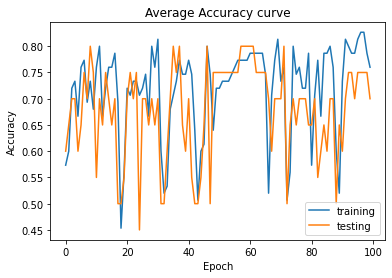

In [0]:
import matplotlib.pyplot as plt

loss=np.array(results.history['loss'])
acuracy=np.array(results.history['accuracy'])
loss_val=np.array(results.history['val_loss'])
accuracy_val=np.array(results.history['val_accuracy'])

plt.plot(acuracy,label='training')
plt.plot(accuracy_val,label='testing')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy curve')
plt.legend()
plt.show()


